In [ ]:
!unzip -q drive/MyDrive/MIL/Pascal-part.zip
!pip install -q segmentation-models-pytorch
!pip install -q catalyst

     |████████████████████████████████| 97 kB 211 kB/s 
     |████████████████████████████████| 376 kB 8.3 MB/s 
     |████████████████████████████████| 58 kB 4.1 MB/s 
     |████████████████████████████████| 446 kB 14.7 MB/s 
     |████████████████████████████████| 125 kB 48.8 MB/s 
     |████████████████████████████████| 148 kB 70.8 MB/s 


In [ ]:
from itertools import chain

import pandas as pd

import segmentation_models_pytorch as smp
import re
import albumentations as albu
from pathlib import Path

from torch import nn, optim
from torch.utils.data import DataLoader

from catalyst.contrib.losses import DiceLoss, IoULoss
from catalyst.callbacks import (DiceCallback, 
                                IOUCallback, 
                                CriterionCallback, 
                                MetricAggregationCallback, 
                                OptimizerCallback)
from catalyst.metrics import iou

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
src_path = Path("Pascal-part")
image_path = src_path / "JPEGImages"
mask_path = src_path / "gt_masks"

# def create_sample(path):
#     return [str(path / file_name) for file_name in sorted(os.listdir(path))]

image_names = create_sample(image_path)
mask_names = create_sample(mask_path)

In [ ]:
# def extract_ids(path):
#     with open(path) as file:
#         ids = file.read().split("\n")
#     return ids

# def extract_name(full_name):
#     return full_name.split("/")[-1].split(".")[0]

# def split_sample(sample, train_ids, val_ids):
#     names_train = [file_name for file_name in sample if extract_name(file_name) in train_ids]
#     names_val = [file_name for file_name in sample if extract_name(file_name) in val_ids]
#     return names_train, names_val

train_ids = extract_ids(src_path / "train_id.txt")
val_ids = extract_ids(src_path / "val_id.txt")

image_names_train, image_names_val = split_sample(image_names, train_ids, val_ids)
mask_names_train, mask_names_val = split_sample(mask_names, train_ids, val_ids)

In [ ]:
classes = []
with open(src_path / "classes.txt") as file:
    for line in file:
        classes.append(re.sub("[^a-z_]+", "", line))

classes

['bg', 'low_hand', 'torso', 'low_leg', 'head', 'up_leg', 'up_hand']

In [ ]:
# class PascalDataset(Dataset):

#     label_counter = Counter()

#     def __init__(self, image_names, mask_names, mode="train", transform=None):
#         if len(image_names) != len(mask_names):
#             raise ValueError("Lengths of image_names and mask_names must be same. " +\
#                              f"Length of image_names = {len(image_names)}, length of mask_names = {len(mask_names)}.")
#         if mode not in ["train", "val"]:
#               raise NameError(f"mode must take values 'train' or 'val', got: {mode}.")
#         self.images = [imread(image_name) for image_name in image_names]
#         self.masks = [np.load(mask_name) for mask_name in mask_names]
#         #self.class_counter = Counter()
#         if mode == "train":
#             for mask in self.masks:
#                 self.label_counter.update(mask.flatten())
#         self.transform = transform or ToTensor()
#         self._len = len(self.images)
#         self.n_classes = len(self.label_counter)

#     def expand_mask(self, mask):
#         mask_expanded = []
#         for label in range(self.n_classes):
#             mask_expanded.append((mask == label).type(torch.int))
#         return torch.stack(mask_expanded)

#     def __len__(self):
#         return self._len
  
#     def __getitem__(self, idx):
#         image = self.images[idx]
#         mask = self.masks[idx]
#         result = {"image" : image, "mask" : mask}
#         result = self.transform(**result)
#         result["mask_expanded"] = self.expand_mask(result["mask"])
#         return result

In [ ]:
p = 0.3
image_size = 224

train_transforms = albu.Compose([
    albu.RandomResizedCrop(image_size, image_size),
    albu.Rotate(p=p),
    albu.HorizontalFlip(p=p),
    albu.VerticalFlip(p=p), 
    albu.GaussianBlur(p=p),
    albu.Normalize(),
    ToTensor()
])

val_transforms = albu.Compose([
    albu.Resize(image_size, image_size),
    albu.Normalize(),
    ToTensor()
])

train_dataset = PascalDataset(image_names_train, mask_names_train, transform=train_transforms)
val_dataset = PascalDataset(image_names_val, mask_names_val, "val", val_transforms)

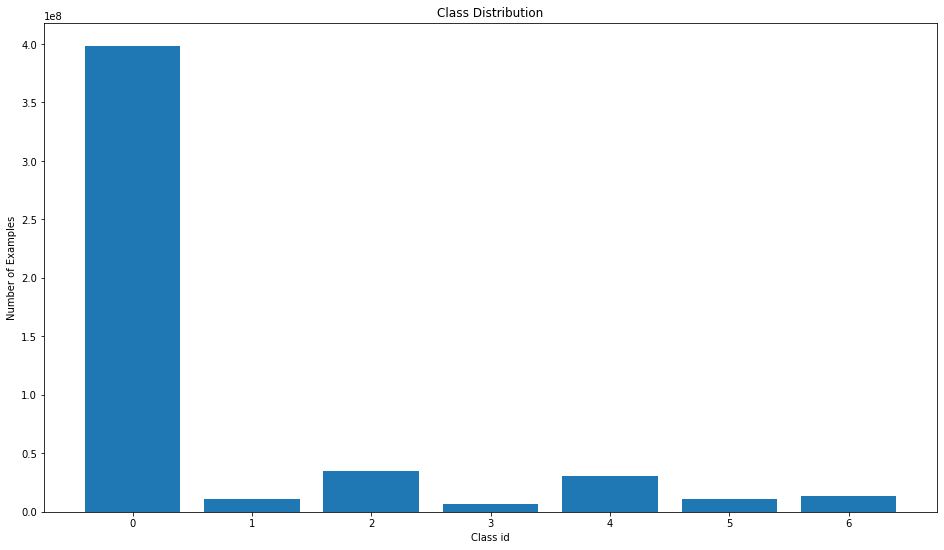

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Сlass Distribution")
plt.ylabel("Number of Examples")
plt.xlabel("Class id")
plt.bar(train_dataset.label_counter.keys(), train_dataset.label_counter.values())
plt.show()

In [ ]:
n_classes = train_dataset.n_classes
counts_sorted = sorted(train_dataset.label_counter.items(), key=lambda x: x[0])
label_counts = list(map(lambda x: x[1], counts_sorted))
n_samples = sum(label_counts)

class_weights = torch.FloatTensor([n_samples / (n_classes * label_count) for label_count in label_counts]).to(device)
class_weights

tensor([ 0.1813,  6.5277,  2.0799, 11.0395,  2.3868,  6.3662,  5.4128],
       device='cuda:0')

In [ ]:
# def visualize(image, mask, pred_mask=None, figsize=(8, 8),
#               mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
#     image = image.permute(1, 2, 0)
#     image = image * torch.tensor(std) + torch.tensor(mean)

#     plt.figure(figsize=figsize)
#     if pred_mask is not None:
#         plt.subplot(1, 3, 1)
#         plt.title("Image")
#         plt.axis("off")
#         plt.imshow(image)

#         plt.subplot(1, 3, 2)
#         plt.title("Mask")
#         plt.axis("off")
#         plt.imshow(mask)

#         plt.subplot(1, 3, 3)
#         plt.title("Mask predicted")
#         plt.axis("off")
#         plt.imshow(mask)

#     else:
#         plt.subplot(1, 2, 1)
#         plt.title("Image")
#         plt.axis("off")
#         plt.imshow(image)

#         plt.subplot(1, 2, 2)
#         plt.title("Mask")
#         plt.axis("off")
#         plt.imshow(mask)
#     plt.show()

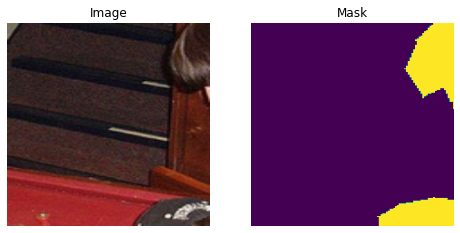

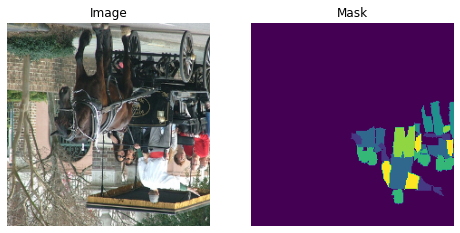

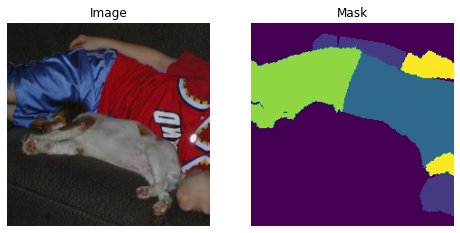

In [ ]:
np.random.seed(42)
n_examples = 3

for i in range(n_examples):
    image, mask, mask_expanded = np.random.choice(train_dataset).values()
    visualize(image, mask)

In [ ]:
# class PascalRunner(SupervisedRunner):
#     def __init__(
#         self,
#         model = None,
#         engine = None,
#         device = "cpu",
#         input_key = "features",
#         output_key = "logits",
#         output_mask_key = "output_mask",
#         target_key = "targets",
#         loss_key = "loss"
#         ):
#         super().__init__(
#             model=model, 
#             engine=engine, 
#             input_key=input_key, 
#             output_key=output_key, 
#             target_key=target_key, 
#             loss_key=loss_key)
#         self._output_mask_key = output_mask_key
#         self.device = device

#     def forward(self, batch, **kwargs):
#         output = self.model(batch[self._input_key], **kwargs)
#         output = {self._output_key: output, 
#                   self._output_mask_key: output.argmax(dim=1)}
#         return output

#     def handle_batch(self, batch):
#         self.batch = {**batch, **self.forward(batch)}
#         self.batch[self._target_key] = self.batch[self._target_key].type(torch.LongTensor).to(self.device)

#     @torch.no_grad()
#     def predict_batch(self, batch, **kwargs):
#         output = self.forward(batch, **kwargs)
#         return output[self._output_mask_key]

#     def predict_loader(self, loader, **kwargs):
#         loader = self.engine.prepare(loader)
#         for batch in loader:
#             yield self.predict_batch(batch, **kwargs)

In [ ]:
num_epochs = 1
batch_size = 32
num_workers = 2
threshold = 0.5
logdir = "./logs/segmentation"

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_dataloader,
    "valid": val_dataloader
}

criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "ce": nn.CrossEntropyLoss(class_weights)
}

model = smp.Unet("resnet50", classes=n_classes, activation=nn.Softmax2d)

optimizer = optim.Adam(
    (
        {
            "params": chain(model.encoder.parameters(), model.decoder.parameters()),
            "lr": 1e-4,
        },
        {
            "params": model.segmentation_head.parameters(),
            "lr" : 1e-2
        }
     )
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

callbacks = [
    CriterionCallback("pred", "mask_expanded", "loss_dice", "dice"),
    CriterionCallback("pred", "mask_expanded", "loss_iou", "iou"),
    CriterionCallback("pred", "mask", "loss_ce", "ce"),
    MetricAggregationCallback(
        "loss",
        {"loss_dice": 1.0, "loss_iou": 1.0, "loss_ce": 0.8},
        "weighted_sum"
        ),
    DiceCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    IOUCallback("pred", "mask_expanded", class_names=classes, threshold=threshold),
    OptimizerCallback("loss")
]

runner = PascalRunner(input_key="image", output_key="pred",
                      output_mask_key="pred_mask", target_key="mask", 
                      device=device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
runner.train(
    loaders=loaders,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    callbacks=callbacks,
    num_epochs=num_epochs,
    logdir=logdir,
    valid_loader="valid",
    valid_metric="iou",
    minimize_valid_metric=False,
    verbose=True
)

1/20 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

train (1/20) dice: 0.4114174544811249 | dice/_macro: 0.4114174544811249 | dice/_micro: 0.7550649046897888 | iou: 0.2990555763244629 | iou/_macro: 0.2990555763244629 | iou/_micro: 0.6065093874931335 | loss: 2.718449831008911 | loss_ce: 1.7313427670324266 | loss_ce/mean: 1.7313427670324266 | loss_ce/std: 0.08637450652629777 | loss_dice: 0.6171505228475904 | loss_dice/mean: 0.6171505228475904 | loss_dice/std: 0.09104293535556973 | loss_iou: 0.7162249926886319 | loss_iou/mean: 0.7162249926886319 | loss_iou/std: 0.07209762634533393 | lr: 0.0001 | momentum: 0.9


1/20 * Epoch (valid):   0%|          | 0/23 [00:00<?, ?it/s]

valid (1/20) dice: 0.5030866861343384 | dice/_macro: 0.5030866861343384 | dice/_micro: 0.8161801695823669 | iou: 0.37734293937683105 | iou/_macro: 0.37734293937683105 | iou/_micro: 0.6894463300704956 | loss: 2.4190964698791504 | loss_ce: 1.5936302568821457 | loss_ce/mean: 1.5936302568821457 | loss_ce/std: 0.03648991502758762 | loss_dice: 0.5110543531272165 | loss_dice/mean: 0.5110543531272165 | loss_dice/std: 0.029799764899833193 | loss_iou: 0.6331380229690963 | loss_iou/mean: 0.6331380229690963 | loss_iou/std: 0.023618568873079837 | lr: 0.0001 | momentum: 0.9
* Epoch (1/20) lr: 0.0001 | momentum: 0.9


2/20 * Epoch (train):   0%|          | 0/89 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: ignored

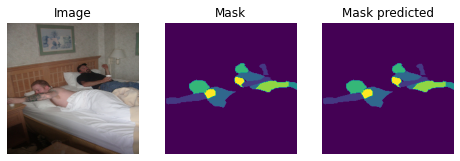

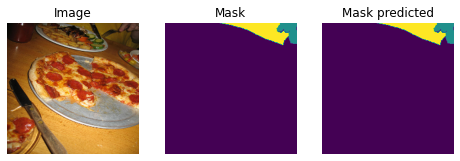

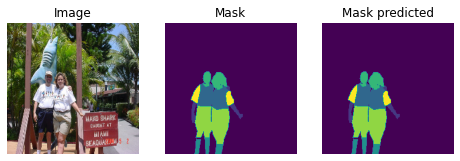

In [ ]:
np.random.seed(42)

for i in range(n_examples):
    data = np.random.choice(val_dataset)
    dl = DataLoader([data])
    image, mask, mask_expanded = data.values()
    pred_mask = torch.cat(list(runner.predict_loader(dl))).cpu().squeeze()#.tolist()
    visualize(image, mask, pred_mask)

In [ ]:
def extract_masks(loader, mask_key="mask"):
    for batch in loader:
        yield batch[mask_key]

def extract_masks_label(masks, labels):
    for mask in masks:
        mask_expanded = []
        for label in labels:
            if isinstance(label, int):
                mask_expanded.append((mask == label).type(torch.int))
            if isinstance(label, list):
                intermediate_mask = torch.zeros_like(mask)
                for label_idx in label:
                    intermediate_mask += (mask == label_idx).type(torch.int)
                mask_expanded.append(intermediate_mask)
        yield torch.stack(mask_expanded)

In [ ]:
true_masks = torch.cat(list(extract_masks(val_dataloader)))
predicted_masks = torch.cat(list(runner.predict_loader(val_dataloader))).cpu()

In [ ]:
body_labels = [[1, 6, 2, 4, 3, 5]]
up_low_labels = [[1, 6, 2, 4], [3, 5]]
parts_labels = list(range(1, 7))

true_masks0 = torch.stack(list(extract_masks_label(true_masks, body_labels)))
true_masks1 = torch.stack(list(extract_masks_label(true_masks, up_low_labels)))
true_masks2 = torch.stack(list(extract_masks_label(true_masks, parts_labels)))

predicted_masks0 = torch.stack(list(extract_masks_label(predicted_masks, body_labels)))
predicted_masks1 = torch.stack(list(extract_masks_label(predicted_masks, up_low_labels)))
predicted_masks2 = torch.stack(list(extract_masks_label(predicted_masks, parts_labels)))

In [ ]:
iou0 = dict(zip(["body"], iou(true_masks0, predicted_masks0).tolist()))
pd.DataFrame(iou0, index=["iou0"])

,body
iou0,0.584912


In [ ]:
iou1 = dict(zip(["upper_body", "lower_body"], iou(true_masks1, predicted_masks1).tolist()))
pd.DataFrame(iou1, index=["iou1"])

,upper_body,lower_body
iou1,0.570458,0.2396


In [ ]:
iou2 = dict(zip(classes[1:], iou(true_masks2, predicted_masks2).tolist()))
pd.DataFrame(iou2, index=["iou"])

SyntaxError: ignored